In [14]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from keras import layers
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.pipeline import Pipeline

import talib as tb
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import yfinance as yf


In [20]:
def format_data(df, avg_days=5):
    
    short_ind = 5
    long_ind = 10
    extra_long_ind = 50
    super_long_ind = 250
    
    # OVERLAP INDICATORS
    df["ma"] = tb.MA(df["Close"], timeperiod=short_ind)
    df["ema"] = tb.EMA(df["Close"], timeperiod=long_ind)
    df["dema"] = tb.DEMA(df["Close"], timeperiod=short_ind)
    df["kama"] = tb.KAMA(df["Close"], timeperiod=short_ind)
    df["sma"] = tb.SMA(df["Close"], timeperiod=long_ind)
    df["sar"] = tb.SAR(df["High"], df["Low"])
    
    df["long_ma"] = tb.MA(df["Close"], timeperiod=extra_long_ind)
    df["long_ema"] = tb.EMA(df["Close"], timeperiod=extra_long_ind)
    
    df["super_ma"] = tb.MA(df["Close"], timeperiod=super_long_ind)
    df["super_ema"] = tb.EMA(df["Close"], timeperiod=super_long_ind)

    # MOMENTUM INDICATORS
    df["adx"] = tb.ADX(df["High"], df["Low"],
                       df["Close"], timeperiod=long_ind)
    df["cci"] = tb.CCI(df["High"], df["Low"],
                       df["Close"], timeperiod=long_ind)
    df["apo"] = tb.APO(df["Close"], fastperiod=long_ind,
                       slowperiod=short_ind)
    df["bop"] = tb.BOP(df["Open"], df["High"], df["Low"], df["Close"])
    df["macd"], df["macdsignal"], df["macdhist"] = tb.MACD(
        df["Close"], fastperiod=12, slowperiod=26, signalperiod=9)
    df["mfi"] = tb.MFI(df["High"], df["Low"], df["Close"],
                       df["Volume"], timeperiod=long_ind)
    df["mom"] = tb.MOM(df["Close"], timeperiod=long_ind)
    df["rsi"] = tb.RSI(df["Close"], timeperiod=long_ind)
    df["adxr"] = tb.ADXR(df["High"], df["Low"], df["Close"], timeperiod=long_ind)
    df["aroon_up"], df["aroon_down"] = tb.AROON(df["High"], df["Low"], timeperiod=long_ind)
    df["cci"] = tb.CCI(df["High"], df["Low"], df["Close"], timeperiod=long_ind)
    
    # OSCILLATOR INDICATORS
    df["stoch"], df["stoch_signal"] = tb.STOCH(df["High"], df["Low"], df["Close"])
    df["rsi"] = tb.RSI(df["Close"], timeperiod=long_ind)
    df["williamsr"] = tb.WILLR(df["High"], df["Low"], df["Close"], timeperiod=long_ind)

    # VOLUME INDICATORS
    df["ad"] = tb.AD(df["High"], df["Low"], df["Close"], df["Volume"])
    df["adosc"] = tb.ADOSC(df["High"], df["Low"], df["Close"],
                           df["Volume"], fastperiod=short_ind, slowperiod=long_ind)
    df["obv"] = tb.OBV(df["Close"], df["Volume"])
    df["trange"] = tb.TRANGE(df["High"], df["Low"], df["Close"])
    df["atr"] = tb.ATR(df["High"], df["Low"],
                       df["Close"], timeperiod=long_ind)
    df["natr"] = tb.NATR(df["High"], df["Low"],
                         df["Close"], timeperiod=long_ind)
    df["roc"] = tb.ROC(df["Close"], timeperiod=long_ind)
    df["cmo"] = tb.CMO(df["Close"], timeperiod=long_ind)
       
    
    # VOLATILITY INDICATORS
    df["bbands_upper"], df["bbands_middle"], df["bbands_lower"] = tb.BBANDS(df["Close"], timeperiod=long_ind)
    df["kc_middle"] = tb.EMA(df["Close"], timeperiod=long_ind)
    df["kc_upper"] = df["kc_middle"] + df["atr"]
    df["kc_lower"] = df["kc_middle"] - df["atr"]

    
    
    df['closingmarubozu'] = tb.CDLCLOSINGMARUBOZU(df["Open"],df["High"],df["Low"],df["Close"])
    df['harami'] = tb.CDLHARAMI(df["Open"],df["High"],df["Low"],df["Close"])
    df['cdlshortline'] = tb.CDLSHORTLINE(df["Open"],df["High"],df["Low"],df["Close"])
    df['spinningtop'] = tb.CDLSPINNINGTOP(df["Open"],df["High"],df["Low"],df["Close"])
    df['cdllongline'] = tb.CDLLONGLINE(df["Open"],df["High"],df["Low"],df["Close"])
    df['breakaway'] = tb.CDLBREAKAWAY(df["Open"],df["High"],df["Low"],df["Close"])
    df['hammer'] = tb.CDLHAMMER(df["Open"], df["High"], df["Low"], df["Close"])
    df['doji'] = tb.CDLDOJI(df["Open"], df["High"], df["Low"], df["Close"])
    df['engulfing'] = tb.CDLENGULFING(df["Open"], df["High"], df["Low"], df["Close"])
    df['morning_star'] = tb.CDLMORNINGSTAR(df["Open"], df["High"], df["Low"], df["Close"])
    df['evening_star'] = tb.CDLEVENINGSTAR(df["Open"], df["High"], df["Low"], df["Close"])
    
    
    trigrams = []
    for i in range(1, len(df)):
        current_row = df.index[i]
        previous_row = df.index[i - 1]
        if (df.loc[current_row, "High"] > df.loc[previous_row, "High"]) & (df.loc[current_row, "Low"] < df.loc[previous_row, "Low"]) & (
                df.loc[current_row, "Close"] > df.loc[previous_row, "Close"]):
            signal = 100  # "BullishHorn"
        elif (df.loc[current_row, "High"] > df.loc[previous_row, "High"]) & (df.loc[current_row, "Low"] < df.loc[previous_row, "Low"]) & (
                df.loc[current_row, "Close"] < df.loc[previous_row, "Close"]):
            signal = -100  # "BearHorn"
        elif (df.loc[current_row, "High"] > df.loc[previous_row, "High"]) & (df.loc[current_row, "Low"] > df.loc[previous_row, "Low"]) & (
                df.loc[current_row, "Close"] > df.loc[previous_row, "Close"]):
            signal = 100  # "BullishHigh"
        elif (df.loc[current_row, "High"] > df.loc[previous_row, "High"]) & (df.loc[current_row, "Low"] > df.loc[previous_row, "Low"]) & (
                df.loc[current_row, "Close"] < df.loc[previous_row, "Close"]):
            signal = -100  # "BearHigh"
        elif (df.loc[current_row, "High"] < df.loc[previous_row, "High"]) & (df.loc[current_row, "Low"] < df.loc[previous_row, "Low"]) & (
                df.loc[current_row, "Close"] > df.loc[previous_row, "Close"]):
            signal = 100  # "BullishLow"
        elif (df.loc[current_row, "High"] < df.loc[previous_row, "High"]) & (df.loc[current_row, "Low"] < df.loc[previous_row, "Low"]) & (
                df.loc[current_row, "Close"] < df.loc[previous_row, "Close"]):
            signal = -100  # "BearLow"
        elif (df.loc[current_row, "High"] < df.loc[previous_row, "High"]) & (df.loc[current_row, "Low"] > df.loc[previous_row, "Low"]) & (
                df.loc[current_row, "Close"] > df.loc[previous_row, "Close"]):
            signal = 100  # "BullishHarami"
        elif (df.loc[current_row, "High"] < df.loc[previous_row, "High"]) & (df.loc[current_row, "Low"] > df.loc[previous_row, "Low"]) & (
                df.loc[current_row, "Close"] < df.loc[previous_row, "Close"]):
            signal = -100  # "BearHarami"
        else:
            signal = 0
        trigrams.append(signal)
    
    df.drop(df.index[0], inplace=True)
    df["trigrams"] = trigrams
    
  
    # TARGET
    df["target"] = df["Close"].pct_change().rolling(avg_days).mean().shift(avg_days)
    
    df.dropna(inplace=True)
    
    return df



data = format_data(yf.download(tickers="AAPL", period="2y"))
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,ma,ema,dema,kama,...,spinningtop,cdllongline,breakaway,hammer,doji,engulfing,morning_star,evening_star,trigrams,target
Date,,,,,,,,,,,,,,,,,,,,,
2022-09-22,152.380005,154.470001,150.910004,152.740005,151.839233,86652500,153.707999,154.881904,153.315272,157.451960,...,100,0,0,0,100,0,0,0,-100,-0.002141
2022-09-23,151.190002,151.470001,148.559998,150.429993,149.542847,96029900,153.653998,154.072466,151.576007,157.409949,...,0,0,0,100,0,0,0,0,-100,-0.008101
2022-09-26,149.660004,153.770004,149.639999,150.770004,149.880859,93339400,152.912000,153.472018,150.864561,156.785975,...,0,0,0,0,0,0,0,0,100,-0.010786
2022-09-27,152.740005,154.720001,149.949997,151.759995,150.865021,84442700,151.884000,153.160741,151.087851,155.716376,...,-100,0,0,0,0,0,0,0,100,0.004083
2022-09-28,147.639999,150.639999,144.839996,149.839996,148.956314,146691400,151.107999,152.556969,150.195108,154.671100,...,0,0,0,0,0,0,0,0,-100,-0.001882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-20,179.259995,179.699997,175.399994,175.490005,175.490005,58436200,176.656003,177.782652,176.370569,178.675034,...,0,-100,0,0,0,-100,0,0,-100,-0.009610
2023-09-21,174.550003,176.300003,173.860001,173.929993,173.929993,63047900,176.294000,177.082168,174.897503,178.530920,...,0,0,0,0,0,0,0,0,-100,-0.002004
2023-09-22,174.669998,177.080002,174.050003,174.789993,174.789993,56663000,176.250000,176.665409,174.613084,178.508344,...,100,0,0,0,100,0,0,0,100,-0.003533


In [21]:
def fit_models(sample, cv=0):
    ITER_SIZE = 5
    _df_list = []

    for col in sample.columns:
        _df = pd.DataFrame()
        _df[col] = sample[col]
        for i in range(ITER_SIZE):
            _df[f"{col}_{i}"] = sample[col].shift(periods=i + 1)
        _df_list.append(_df)

    _df = pd.concat(_df_list, axis=1)
    
    sample = _df
    
    
    

    X = sample.dropna().drop(["target"], axis=1)
    X = X.dropna().drop([f"target_{i}" for i in range(ITER_SIZE)], axis=1)
    
    sample.dropna(inplace=True)
    y = sample[
        "target"].shift(-1).apply(lambda x: 1 if x>0 else 0)
        
        
    scaler = StandardScaler()
    pipeline = Pipeline(steps=[("scaler", scaler), ])
    X = pipeline.fit_transform(X)
    
    split_size = int(len(X) * 0.8)
    X_train, y_train = X[:split_size], y[:split_size]
    X_test, y_test = X[split_size:], y[split_size:]
    
    y_train = np.stack(y_train.values.tolist(), axis=0)
    y_test = np.stack(y_test.values.tolist(), axis=0)
    X_train = np.asarray(X_train).astype(np.float32)
    y_train = np.asarray(y_train).astype(np.float32)
    X_test = np.asarray(X_test).astype(np.float32)
    y_test = np.asarray(y_test).astype(np.float32)
    
    X_train_lstm = X_train.reshape(X_train.shape[0], -1, ITER_SIZE+1)
    X_test_lstm = X_test.reshape(X_test.shape[0], -1, ITER_SIZE+1)
    
    y_preds = [] 
    
    print("\tFitting Models...")
    
    svm = SVC(C=1, gamma=0.1)
    svm.fit(X_train, y_train)
    y_preds.append(svm.predict(X_test).astype(int))
    
    knn = KNeighborsClassifier(n_neighbors=150, weights="distance", algorithm="auto", leaf_size=1)
    knn.fit(X_train, y_train)
    y_preds.append(knn.predict(X_test).astype(int))
    
    rf = RandomForestClassifier(n_estimators=9, criterion="gini", min_samples_leaf=5, max_depth=1)
    rf.fit(X_train, y_train)
    y_preds.append(rf.predict(X_test).astype(int))
    
    gb = GradientBoostingClassifier(n_estimators=1, max_features=7, max_depth=1)
    gb.fit(X_train, y_train)
    y_preds.append(gb.predict(X_test).astype(int))
    
    xgb_model = xgb.XGBClassifier(n_estimators=10, max_depth=3, min_child_weight=10, gamma=0, learning_rate=0.1, seed=27, subsample=0.65)
    xgb_model.fit(X_train,y_train)
    y_preds.append(xgb_model.predict(X_test).astype(int))
    
    lstm = Sequential([
    layers.Input((X_train_lstm.shape[1], ITER_SIZE + 1)),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(64),
    layers.Dense(32, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="sigmoid")
    ])
    
    lstm.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])
    
    lstm.fit(X_train_lstm, y_train, epochs=100, verbose=0)
    y_preds.append((lstm.predict(X_test_lstm).flatten() >= 0.5).astype(int))


    return y_preds, y_test.astype(int)

preds, y_test = fit_models(data)




	Fitting Models...
2/2 [==============================] - 1s 14ms/step


In [22]:
def score_predictions(ticker,y_test ,y_pred,average="binary"):
          
    
    df = pd.DataFrame({"ticker": ticker,
                    "svm_acc": metrics.accuracy_score(y_test, y_pred[0]),
                    "svm_prec": metrics.precision_score(y_test, y_pred[0], average=average),
                    "svm_recall": metrics.recall_score(y_test, y_pred[0], average=average),
                    "svm_f1": metrics.f1_score(y_test, y_pred[0], average=average),
                    "knn_acc": metrics.accuracy_score(y_test, y_pred[1]),
                    "knn_prec": metrics.precision_score(y_test, y_pred[1], average=average),
                    "knn_recall": metrics.recall_score(y_test, y_pred[1], average=average),
                    "knn_f1": metrics.f1_score(y_test, y_pred[1], average=average),
                    "rf_acc": metrics.accuracy_score(y_test, y_pred[2]),
                    "rf_prec": metrics.precision_score(y_test, y_pred[2], average=average),
                    "rf_recall": metrics.recall_score(y_test, y_pred[2], average=average),
                    "rf_f1": metrics.f1_score(y_test, y_pred[2], average=average),
                    "gb_acc": metrics.accuracy_score(y_test, y_pred[3]),
                    "gb_prec": metrics.precision_score(y_test, y_pred[3], average=average),
                    "gb_recall": metrics.recall_score(y_test, y_pred[3], average=average),
                    "gb_f1": metrics.f1_score(y_test, y_pred[3], average=average),
                    "xgb_acc": metrics.accuracy_score(y_test, y_pred[4]),
                    "xgb_prec": metrics.precision_score(y_test, y_pred[4], average=average),
                    "xgb_recall": metrics.recall_score(y_test, y_pred[4], average=average),
                    "xgb_f1": metrics.f1_score(y_test, y_pred[4], average=average),
                    "lstm_acc": metrics.accuracy_score(y_test, y_pred[5]),
                    "lstm_prec": metrics.precision_score(y_test, y_pred[5], average=average),
                    "lstm_recall": metrics.recall_score(y_test, y_pred[5], average=average),
                    "lstm_f1": metrics.f1_score(y_test, y_pred[5], average=average), }, index=[0])
    
    return df

score = score_predictions(ticker="AAPL", y_pred=preds, y_test=y_test)

In [23]:
score

,ticker,svm_acc,svm_prec,svm_recall,svm_f1,knn_acc,knn_prec,knn_recall,knn_f1,rf_acc,...,gb_recall,gb_f1,xgb_acc,xgb_prec,xgb_recall,xgb_f1,lstm_acc,lstm_prec,lstm_recall,lstm_f1
0,AAPL,0.42,0.42,1.0,0.591549,0.42,0.42,1.0,0.591549,0.8,...,1.0,0.591549,0.86,0.85,0.809524,0.829268,0.48,0.444444,0.952381,0.606061


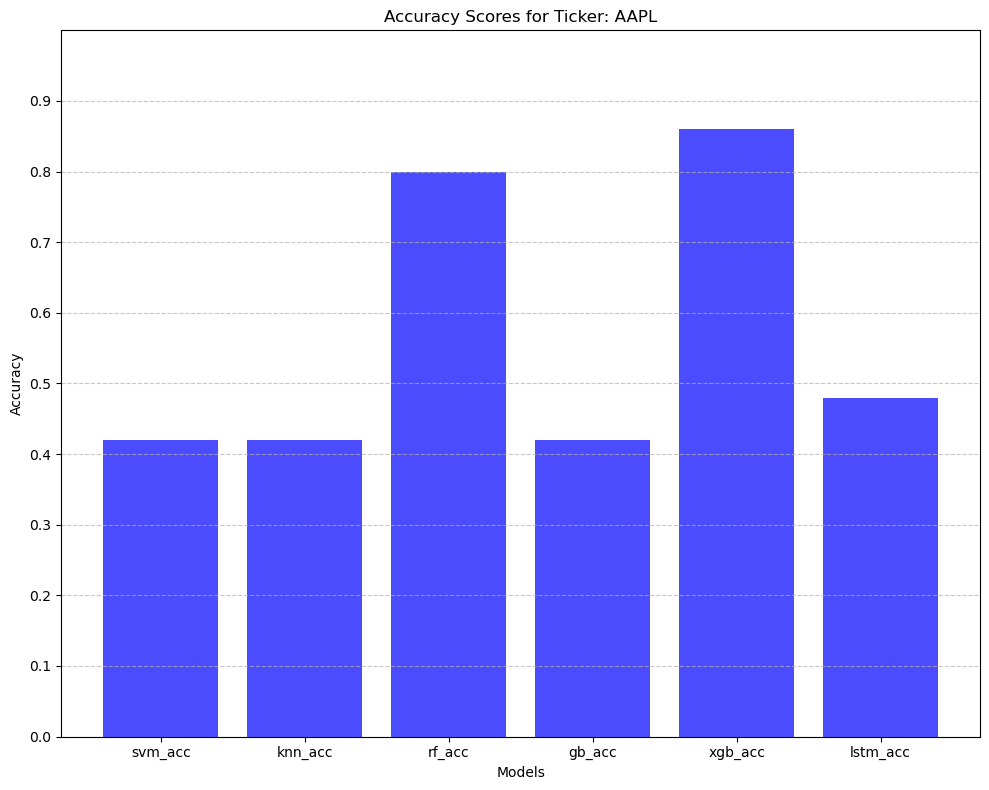

In [24]:
def plot_scores(score_df):
  
    columns_to_plot = ["svm_acc", "knn_acc", "rf_acc", "gb_acc", "xgb_acc","lstm_acc"]
    
    ticker = score_df["ticker"].values[0]
    scores = score_df[columns_to_plot].values[0]

    plt.figure(figsize=(10, 8))
    plt.bar(columns_to_plot, scores, color='blue', alpha=0.7)
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy Scores for Ticker: {ticker}')
    plt.yticks(np.arange(0,1,0.1))
    plt.ylim(0, 1.0)  
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


plot_scores(score)